In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.feature_selection import RFECV, SequentialFeatureSelector
from tqdm import tqdm
import sys
sys.path.append('../')

from TS_model.feature_engeneering import FeatureEngineer
from TS_model.feature_selection import WrapperMethod, StabilityAnalysis, DefaultMethod, FilterMethod

%load_ext autoreload
%autoreload 2

# Выгрузка изначальных данных & Feature engeneering

In [2]:
data = pd.read_excel('../Data/full_features_data.xlsx', index_col=0)
features, target = data.drop('balance', axis=1), data['balance']

# Feature selection

In [3]:
tscv = TimeSeriesSplit(n_splits=5)

## Встроенные методы

Index(['balance_lag1', 'outcome_lag1', 'outcome_lag2', 'outcome_lag3',
       'balance_lag7', 'month', 'day_of_week_sin', 'day_of_week_cos', 'dow_0',
       'dow_3', 'digitalization_level', 'age_65_plus', 'population_density',
       'inflation_rate', 'close'],
      dtype='object')


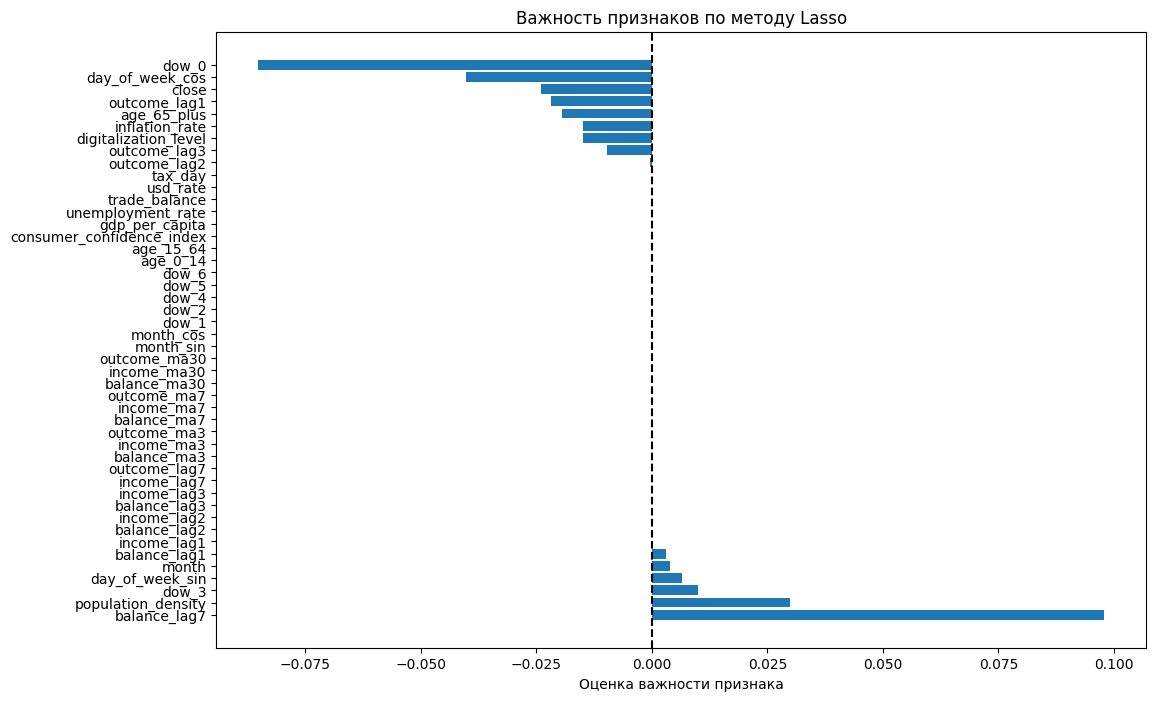

In [4]:
default = DefaultMethod()
default.fit(features, target)

lasso = LassoCV(cv=tscv, max_iter=10000, random_state=42)
print(default.implement(lasso))
default.vizualize()

Index(['balance_lag1', 'income_lag1', 'outcome_lag1', 'balance_lag2',
       'income_lag2', 'outcome_lag2', 'balance_lag3', 'income_lag3',
       'outcome_lag3', 'balance_lag7', 'income_lag7', 'outcome_lag7',
       'balance_ma3', 'income_ma3', 'outcome_ma3', 'balance_ma7', 'income_ma7',
       'outcome_ma7', 'balance_ma30', 'income_ma30', 'outcome_ma30', 'month',
       'day_of_week_cos', 'month_sin', 'month_cos', 'dow_0', 'close',
       'usd_rate'],
      dtype='object')


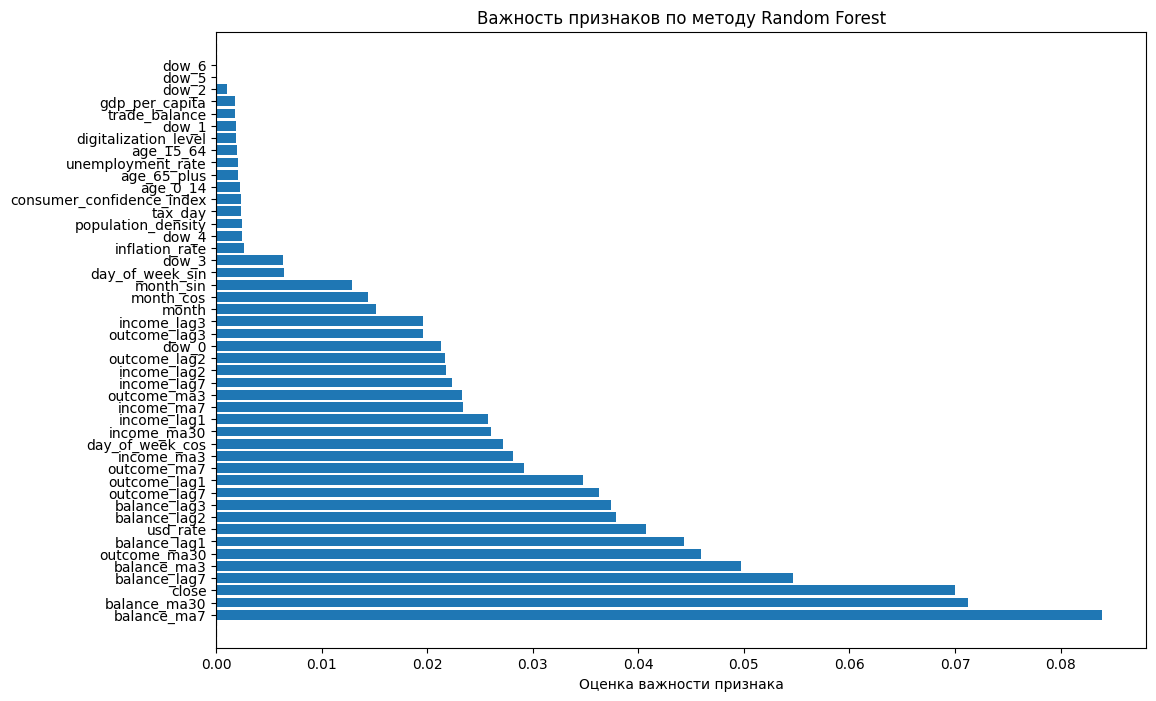

In [5]:
default = DefaultMethod()
default.fit(features, target)

random_forest = RandomForestRegressor(n_estimators=500, random_state=42)
print(default.implement(random_forest))
default.vizualize()

## Оберточные методы

/Users/legornevas/Desktop/TS_project/ts_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000583831819310987, tolerance: 0.0004947468060591708
  model = cd_fast.enet_coordinate_descent_gram(
/Users/legornevas/Desktop/TS_project/ts_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001556207347657157, tolerance: 0.0004947468060591708
  model = cd_fast.enet_coordinate_descent_gram(
/Users/legornevas/Desktop/TS_project/ts_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013385422830554106, tolerance: 0.0004968842459976319
  model = cd_fast.enet_coordinate

Отобранные признаки на основе lasso: Index(['balance_lag7', 'dow_0', 'dow_3', 'age_65_plus', 'population_density'], dtype='object')


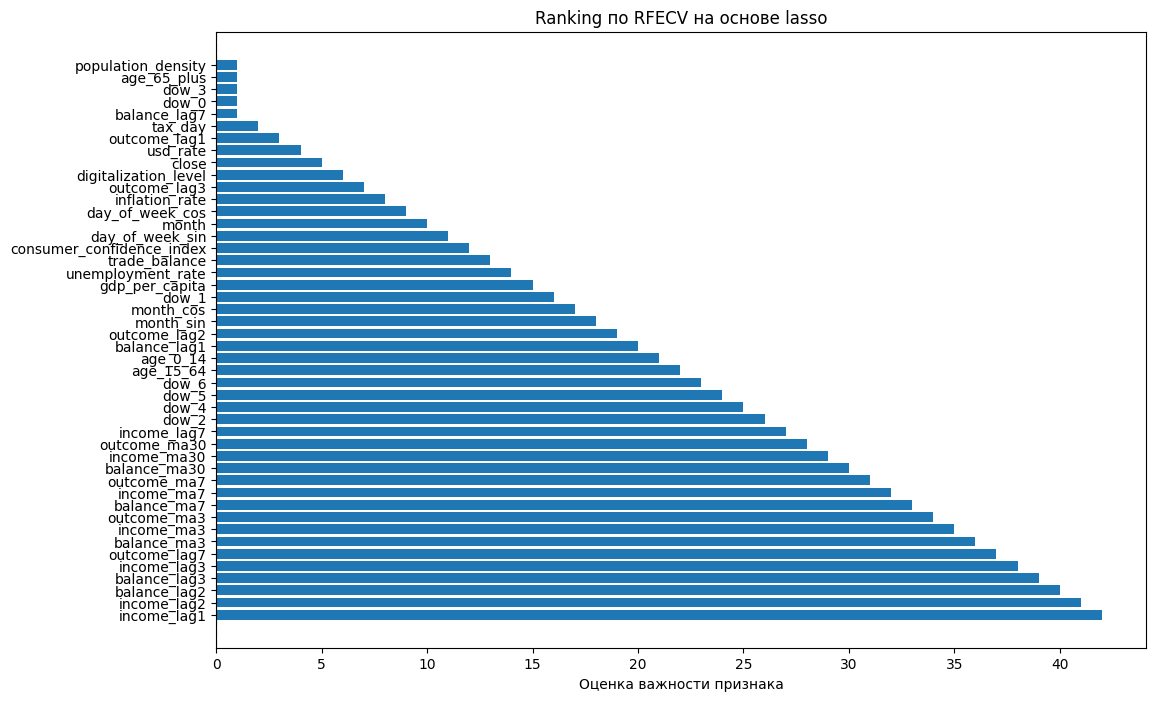

Отобранные признаки на основе elastic_net: Index(['balance_lag7', 'dow_0', 'dow_3', 'age_15_64', 'tax_day'], dtype='object')


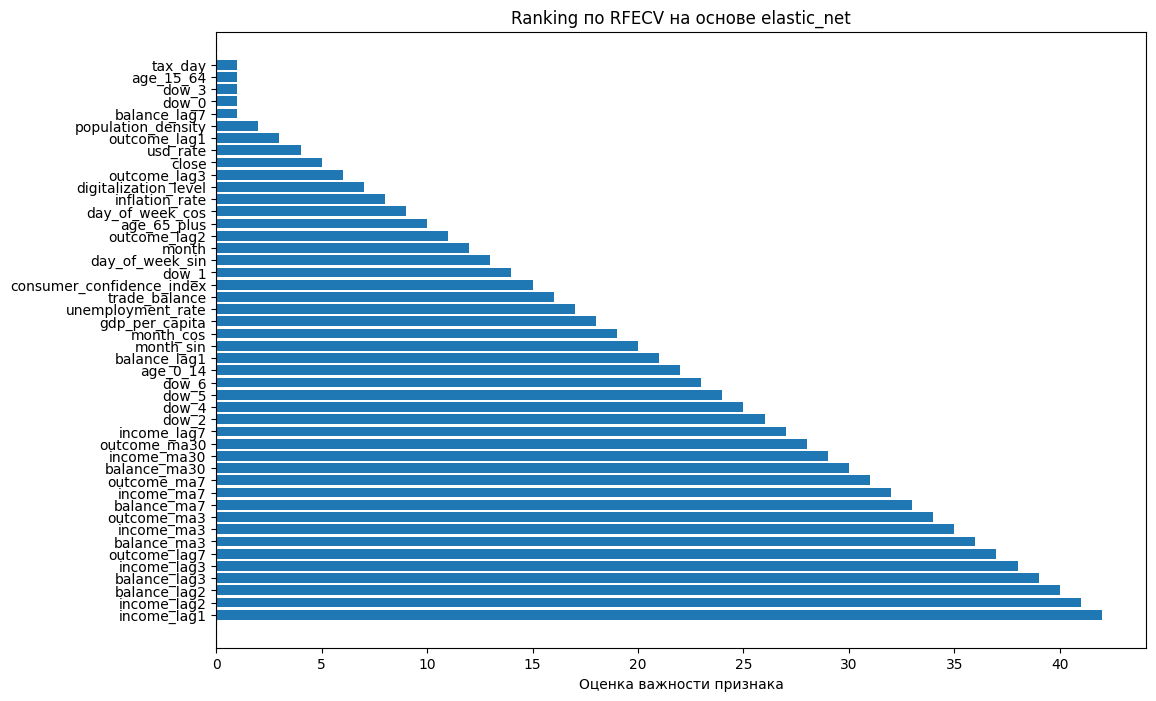

Отобранные признаки на основе random_forest: Index(['outcome_lag1', 'balance_lag7', 'balance_ma3', 'balance_ma7',
       'balance_ma30', 'close'],
      dtype='object')


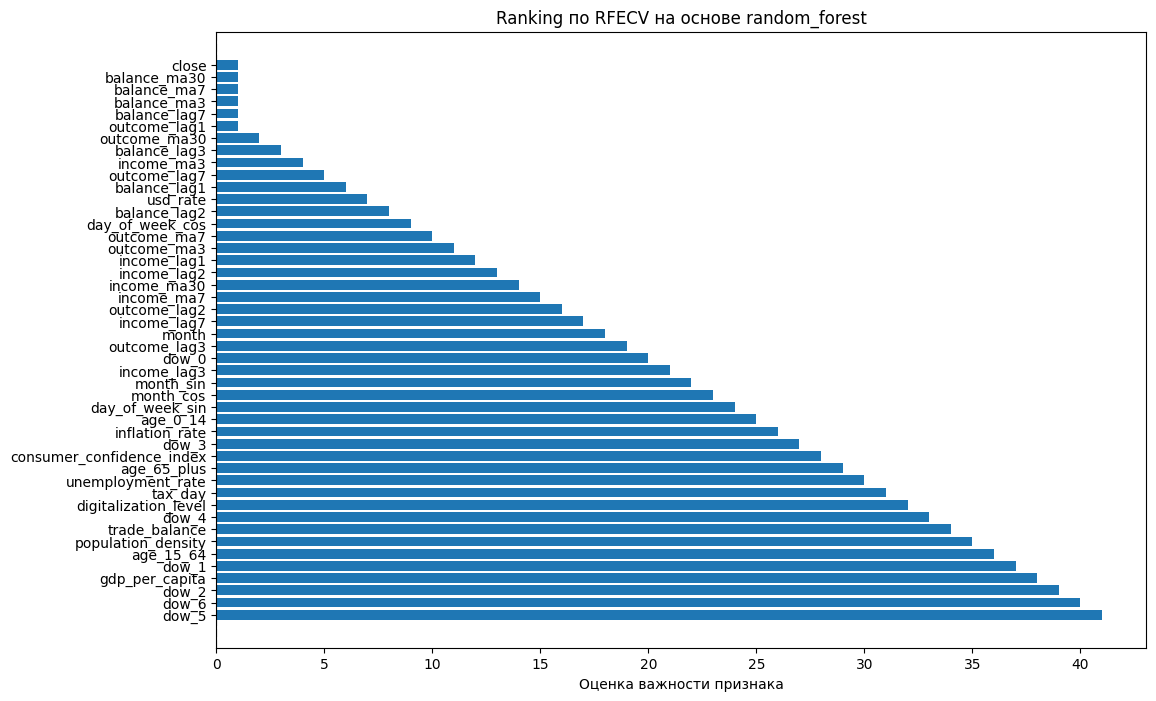

In [6]:
models_for_wrapper = {
    'lasso': LassoCV(cv=tscv, max_iter=10000, random_state=42),
    'elastic_net': ElasticNetCV(cv=tscv, max_iter=10000, random_state=42),
    'random_forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

wrapper = WrapperMethod()
wrapper.fit(features, target)

for name, model in models_for_wrapper.items():
    res = wrapper.implement(model, tscv)
    print(f'Отобранные признаки на основе {name}: {res}', end='\n')

    wrapper.vizualize(f'Ranking по RFECV на основе {name}')

## Фильтрационные методы

['month', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'dow_4', 'digitalization_level', 'age_0_14', 'age_15_64', 'age_65_plus', 'population_density', 'consumer_confidence_index', 'gdp_per_capita', 'unemployment_rate', 'trade_balance', 'inflation_rate']


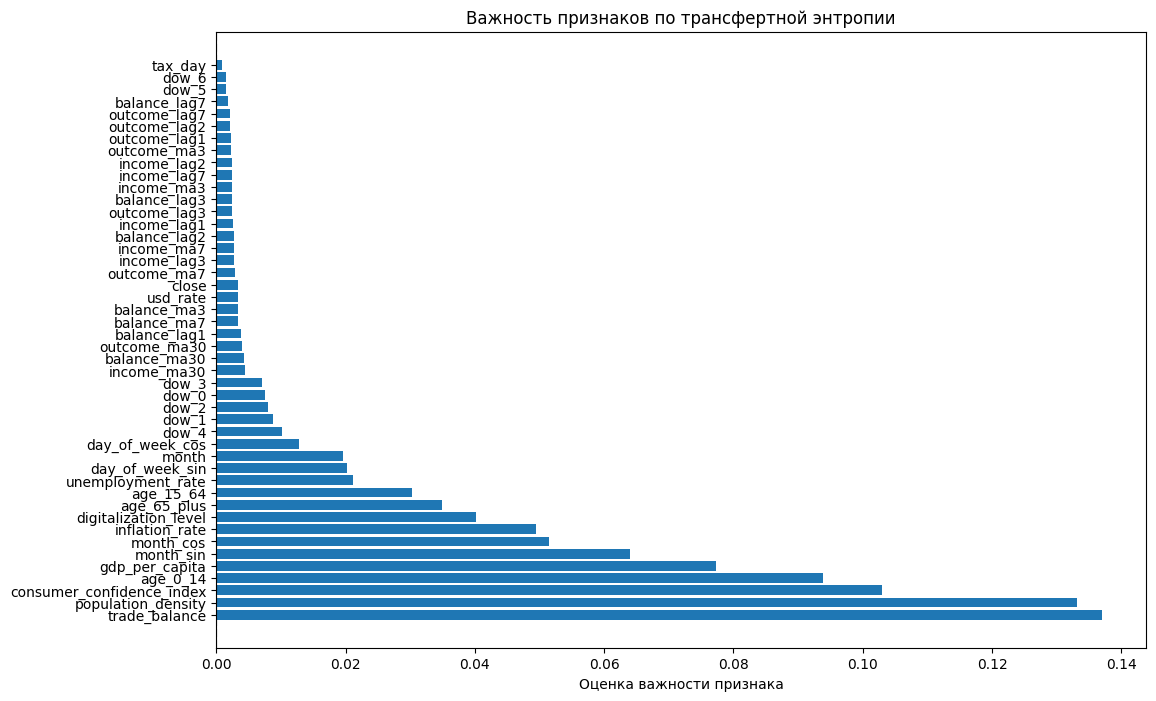

In [7]:
filter = FilterMethod()
filter.fit(features, target)

print(filter.implement(k=30))
filter.vizualize('Важность признаков по трансфертной энтропии')

# Оценка стабильности

In [8]:
method_params = {
    'default': {
        'Lasso': {'model': LassoCV(cv=tscv, max_iter=10000, random_state=42)},
        'RandomForest': {'model': RandomForestRegressor(n_estimators=500, random_state=42)}
    },
    'wrapper': {
        # 'Lasso': {'model': LassoCV(cv=tscv, max_iter=10000, random_state=42), 'tscv': tscv},
        # 'ElasticNet': {'model': ElasticNetCV(cv=tscv, max_iter=10000, random_state=42), 'tscv': tscv},
        'RandomForest': {'model': RandomForestRegressor(n_estimators=100, random_state=42), 'tscv': tscv}
    },
    'filter': {
        'TransferEntropy': {'k': 5}
    }
}

methods = []
method_configs = []
stabilities = []

stability_eval = StabilityAnalysis()
stability_eval.fit(features, target)

for method, params in tqdm(method_params.items()):
    for method_config, param in params.items():
        stability_eval.collect_binary(n_splits=5, method=method, **param)
        method_stability = stability_eval.implement()

        methods.append(method)
        method_configs.append(method_config)
        stabilities.append(method_stability)

  0%|          | 0/3 [00:00<?, ?it/s]/Users/legornevas/Desktop/TS_project/ts_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013385422830554106, tolerance: 0.0004968842459976319
  model = cd_fast.enet_coordinate_descent_gram(
/Users/legornevas/Desktop/TS_project/ts_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021756444086986626, tolerance: 0.0004968842459976319
  model = cd_fast.enet_coordinate_descent_gram(
/Users/legornevas/Desktop/TS_project/ts_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023297870465275317, tolerance: 0.00049688424599

In [9]:
pd.DataFrame(
    {
        'method': methods,
        'method_config': method_configs,
        'stability': stabilities
    }
)

,method,method_config,stability
0,default,Lasso,0.193156
1,default,RandomForest,0.927536
2,wrapper,RandomForest,0.375000
3,filter,TransferEntropy,0.400561


# Сохранение отобранных признаков в отдельный excel файл для обучения модели 

In [13]:
chosen_features = [
    'balance_lag1', 'income_lag1', 'outcome_lag1', 'balance_lag2',
    'income_lag2', 'outcome_lag2', 'balance_lag3', 'income_lag3',
    'outcome_lag3', 'balance_lag7', 'income_lag7', 'outcome_lag7',
    'balance_ma3', 'income_ma3', 'outcome_ma3', 'balance_ma7', 'income_ma7',
    'outcome_ma7', 'balance_ma30', 'income_ma30', 'outcome_ma30', 'month',
    'day_of_week_cos', 'month_sin', 'month_cos', 'dow_0', 'close', 'usd_rate'
]
chosen_features.append('balance')

In [14]:
chosen_features_df = data[chosen_features]
chosen_features_df.to_excel('../Data/chosen_features.xlsx')